# OpenCVを利用した葉面積の推定

Pythonで画像を扱うためのライブラリでよく使われるものに、OpenCVがあります。
今回はこのOpenCVを用いて、作物成長段階の指標となる葉面積を推定します。

まずはOpenCVモジュールを読み込みます。
以下のチャンクを実行すると、今動いているPythonの環境にOpenCVの機能が追加されます。

In [1]:
import cv2

作業しているパソコンにOpenCVがインストールされていない場合は、エラーが出ますので、以下のコマンドでインストールして、再度実行してください。

In [2]:
!pip install opencv-python

うまくインストールされれば、以下のコマンドでバージョンが表示されます。

In [3]:
cv2.__version__

'4.4.0'

## OpenCVでの画像の表示

まずは画像を読み込んで表示します。画像の保存先は、`.ipynb`ファイルと同じフォルダに、`data`という名前のフォルダを作成し、その中に保存してあるものとします。

下記のチャンクを実行すると、**image**という名前の別ウィンドウが立ち上がり、画像が表示されます。(Jupyter labをWSL2上やGoogle Colaboratoryで動かしている場合、下のコードは機能しないかもしれません。)
表示されたウィンドウは、キーボードのいづれかのキーを押して閉じてください。

In [4]:
# ファイルへのパスをimage_path変数に代入する。
# image_path = 'data/field.jpg'
image_path = 'data/field_2.jpg'

# 画層をOpenCVのimage形式で読み込む
img = cv2.imread(image_path)

# OpenCV のimshow関数で、画像を表示する
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

上のチャンクを実行すると、別ウィンドウで次の画像が表示されます。

![field](data/field_2.jpg)

表示されたウィンドウを閉じてもチャンクの番号が`[*]`と表示されたままの場合は、Jupyter NotebookメニューのKernel -> Restart Kernelで、カーネルを再起動してください。  

画像の表示はこの方法でもいいですが、**matplotlib**というライブラリを利用して、Jupyter Notebook内にインラインで表示させる下記の方法がよく用いられます。

まずは**matplotlib**をインポートします。(必要であればmatplotlibを`!pip install matplotlib` からインストールしてください。)

In [5]:
import matplotlib.pyplot as plt

ここでは、`matplotlib`ライブラリ内の`pyploy`というサブモジュールを`plt`という別名でインポートしました。このように別名を使ってインポートすることにより、たとえば`matplotlib.pyplot.imshow()`と書く代わりに、`plt.imshow()`と書くことができるようになります。

import文はプログラムの一番最初にまとめて記述することが慣例ですが、ここでは必要になる箇所で適宜宣言することにします。

では、`matplotlib`の`matshow`関数を使って画像を表示しましょう。

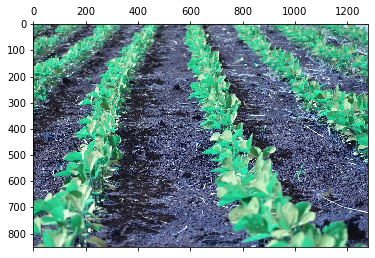

In [6]:
plt.matshow(img)

色が変ですね。

これは、**OpenCV**と**matplotlib**でのデフォルトのRGBチャンネルの順序が異なるため、赤と青が入れ替わってしまっているからです。  
OpenCVはBGRの順、matplotlibはRGBの順でカラーを取り扱います。
正しく読み込むには以下のように読み込みます。

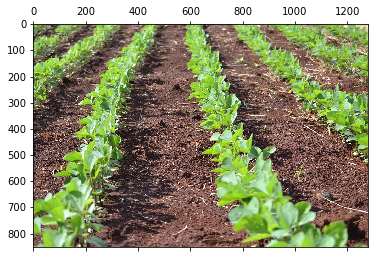

In [7]:
# 画層をRGBの順で読み込む
img_bgr = cv2.imread(image_path)

# cvtColor() 関数でBGRからRGBへ変換する
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# matplotlibで表示
plt.matshow(img_rgb)

`.jpg`ファイルとして保存された写真をPythonで表示することができました。

## 画像データとはなにか
写真や衛星画像のようなデータはラスタデータと呼ばれ、一定の間隔で格子状に区切られた各グリッドに値をもったデータ形式です。それぞれのグリッドのことをピクセルと呼ぶので、ピクセルデータと呼ぶこともあります。上で画像をプロットした際に、X軸とY軸に数値が振られていますが、この数値が画像のピクセルを表しています。通常左上を起点とした座標で表されます。  
ラスタデータと対になるデータはベクタデータです。分野によっては、ベクタデータは、ベクトル、ポリゴンなどとも呼ばれます。

詳しくはESRIのサイトに解説があるので、参考にしてください。[ベクターデータとは:www.esrij.com](https://www.esrij.com/gis-guide/gis-datamodel/vector-data/)、 [ラスターデータとは:wwww.esrij.com](https://www.esrij.com/gis-guide/gis-datamodel/raster-data/)

今回読み込んだ画像はラスタデータです。ここではPythonの中でどのように保存されているかを見ていきます。

まずは、`print()`関数を用いて、作成した`img_bgr`をそのまま表示させてみます。

In [8]:
print(img_bgr)

[[[ 71 205 152]
  [ 68 202 149]
  [ 68 199 148]
  ...
  [ 43  66  92]
  [ 68  95 121]
  [105 136 161]]

 [[ 70 206 154]
  [ 68 204 152]
  [ 64 200 148]
  ...
  [ 58  85 111]
  [ 78 109 134]
  [107 143 167]]

 [[ 67 206 155]
  [ 64 203 152]
  [ 59 198 147]
  ...
  [ 76 113 135]
  [ 85 126 149]
  [102 146 169]]

 ...

 [[187 217 252]
  [191 219 254]
  [181 206 246]
  ...
  [104 120 143]
  [ 98 103 128]
  [ 90  91 117]]

 [[168 197 224]
  [184 210 240]
  [189 214 246]
  ...
  [115 136 157]
  [104 115 137]
  [ 90  96 119]]

 [[150 175 195]
  [163 187 209]
  [167 190 216]
  ...
  [117 142 158]
  [101 116 135]
  [ 82  93 113]]]


In [9]:
img_rgb.shape

(853, 1280, 3)

## チャンネルの分解

In [10]:
r, g, b = cv2.split(img_rgb)
r.shape

(853, 1280)

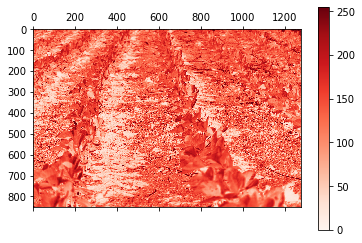

In [11]:
plt.matshow(r, cmap='Reds')
plt.colorbar()
plt.show()

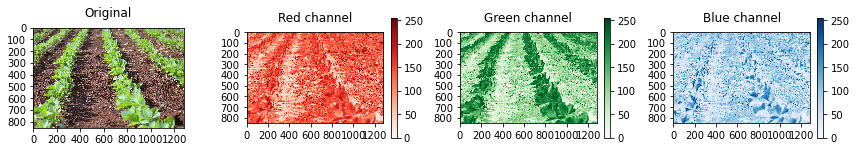

In [12]:
channels = [img_rgb, r, g, b]
colors = (None, 'Reds','Greens','Blues')
titles = ('Original', 'Red channel', 'Green channel', 'Blue channel')

fig, axs = plt.subplots(1, 4, figsize=(12,3))  # figとaxを作成
for idx, (title, channel, color) in enumerate(zip(titles, channels, colors)):
    axs[idx].set_title(title)
    ax = axs[idx].matshow(channel, cmap=color)
    axs[idx].xaxis.tick_bottom()    
    if color:
        fig.colorbar(ax, ax=axs[idx], fraction=0.04)

plt.tight_layout()
plt.show()

## HSVへの変換

In [13]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
img_hsv.shape

(853, 1280, 3)

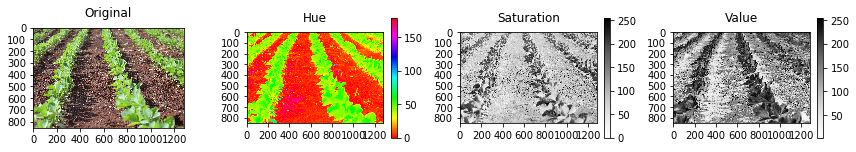

In [14]:
channels = h, s, v = cv2.split(img_hsv)
channels.insert(0, img_rgb)
colors = (None, 'hsv','Greys','Greys')
titles = ('Original', 'Hue', 'Saturation', 'Value')

fig, axs = plt.subplots(1, 4, figsize=(12,3))  # figとaxを作成
for idx, (title, channel, color) in enumerate(zip(titles, channels, colors)):
    axs[idx].set_title(title)
    ax = axs[idx].matshow(channel, cmap=color)
    axs[idx].xaxis.tick_bottom()    
    if color:
        fig.colorbar(ax, ax=axs[idx], fraction=0.04)
plt.tight_layout()
plt.show()

In [15]:
# ある地点のピクセル値を取得する
x=999
y=200
img_rgb[y, x, :]

array([ 95, 128,  73], dtype=uint8)

In [16]:
# 複数地点のピクセル

## 閾値による分類

In [17]:
import numpy as np

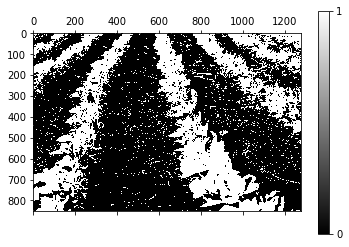

In [18]:
g_min = 150
g_max = 250
img_bin = (g_min < g) & (g < g_max) * 1
# plt.imshow(img_bin, cmap='binary_r')
plt.matshow(img_bin, cmap='binary_r')
plt.colorbar(ticks=[0, 1])
plt.show()

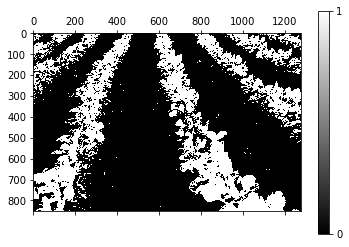

In [19]:
h_min = 40
h_max = 60
img_bin = (h_min < h) & (h < h_max) * 1
plt.matshow(img_bin, cmap='binary_r')
plt.colorbar(ticks=[0, 1])
plt.show()

In [20]:
print(f'Mask ratio is {img_bin.sum()/img_bin.size}')

Mask ratio is 0.2845270369284877


In [21]:
import random
def plot_3d(img, sampling=1000, mask=None, **kwargs):
    xlab, ylab, zlab = 'R', 'G', 'B'
    y,x,z = img.shape
    img_flat = np.reshape(img, (x*y,z))
    if mask is not None:
        mask_flat = np.reshape(mask, (x*y)).astype('bool')
        img_flat = img_flat[mask_flat, :]
        
    if sampling != 0:
        # random sample 
        img_flat = img_flat[np.random.choice(len(img_flat), sampling, replace=False)]
    colors = img_flat / 255
    fig = plt.figure(**kwargs)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=img_flat[:,0],
               ys=img_flat[:,1],
               zs=img_flat[:,2],
               s=10,
               c=colors,
               lw=0)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_zlabel(zlab)
    plt.show()

# matplotlibのインタラクティブプロットを有効化
%matplotlib widget

plot_3d(img = img_rgb,
        mask=img_bin,
        sampling=1000,
        figsize=(10,10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
# インタラクティブを無効化
%matplotlib inline